In [2]:
import pandas as pd
import nltk,re, string, spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [3]:
df = pd.read_csv('/content/imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [5]:
class Preprocessor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer(language='english')
        self.lemmatizer = WordNetLemmatizer()

    def _remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))

    def _remove_html_tags(self, text):
        return re.sub(r'<.*?>', '', text)

    def _lowercase(self, text):
        return text.lower()

    def _word_tokenize(self, text):
        return [token.text for token in self.nlp(text)]

    def _sent_tokenize(self, text):
        return [sent.text for sent in self.nlp(text).sents]

    def _remove_stopwords(self, text):
        tokens = self._word_tokenize(text)
        return ' '.join([word for word in tokens if word.lower() not in self.stopwords])

    def _stemming(self, text):
        return ' '.join(self.stemmer.stem(word) for word in word_tokenize(text))

    def _lemmatization(self, text):
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN

        tokens = word_tokenize(text)
        pos_tagged = pos_tag(tokens)
        return ' '.join(self.lemmatizer.lemmatize(word, pos_tagger(tag)) for word, tag in pos_tagged)
    def apply_operations(self, text):
        text = self._remove_html_tags(text)
        text = self._lowercase(text)
        text = self._remove_punctuation(text)
        text = self._remove_stopwords(text)
        text = self._lemmatization(text)

        return text

In [6]:
df.shape

(50000, 2)

In [7]:
df.isnull().sum()

,0
review,0
sentiment,0


In [8]:
df.duplicated(['review','sentiment']).sum()

418

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(49582, 2)

**Plotting count of positive and negative sentiment**

In [11]:
positive = df[df['sentiment'] == 'positive']
negative = df[df['sentiment'] == 'negative']
count = {"positive": len(positive), "negative": len(negative)}
count_df = pd.DataFrame(count.items(),columns=['Sentiment','Count'])
count_df

,Sentiment,Count
0,positive,24884
1,negative,24698


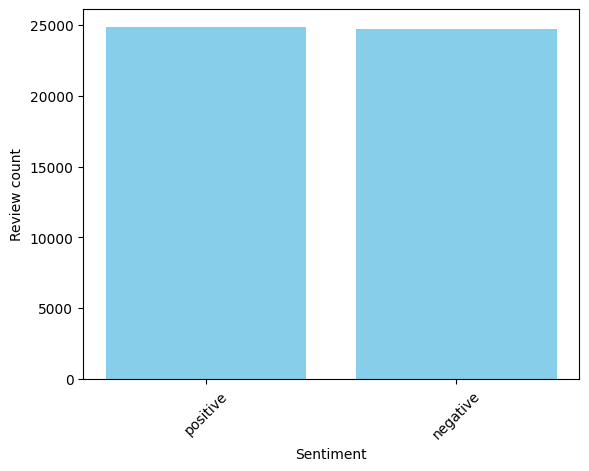

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.bar(count_df['Sentiment'],count_df['Count'],color="skyblue")
plt.xlabel('Sentiment')
plt.ylabel('Review count')
plt.xticks(rotation=45)
plt.show()

**Preprocessing on dataset**

*   Remove HTML tags
*   Remove punctuation
*   Lowercasing of sentences
*   Stemming
*   Lemmetization





In [13]:
obj = Preprocessor()

In [16]:
tqdm.pandas()
df['review'] = df['review'].progress_apply(obj.apply_operations)

100%|██████████| 49582/49582 [15:17<00:00, 54.05it/s]


**Saving stemmed data and lemmetized data in csv files**

In [17]:
df.to_csv('preprocessed_imdb_data.csv')

In [18]:
import pandas as pd
new_df = pd.DataFrame(pd.read_csv('/content/preprocessed_imdb_data.csv'))
new_df.head()

,Unnamed: 0,review,sentiment
0,0,one reviewer mention watch 1 oz episode hook r...,positive
1,1,wonderful little production film technique una...,positive
2,2,think wonderful way spend time hot summer week...,positive
3,3,basically family little boy jake think zombie ...,negative
4,4,petter matteis love time money visually stunni...,positive


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

**Encoding data for training Using BOW and testing different ML models**
1.   Gaussian Naive Bayes
2.   Decision Tree
3.   Random Forest



In [20]:
X = new_df.drop(['sentiment'],axis=1)
y = new_df['sentiment']

In [21]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=10)
X_train.shape, X_test.shape

((39665, 2), (9917, 2))

In [23]:
cv = CountVectorizer(max_features=20000)
X_train_bow = cv.fit_transform(X_train['review']).toarray()
X_test_bow = cv.transform(X_test['review']).toarray()
X_train_bow.shape, X_test_bow.shape

((39665, 20000), (9917, 20000))

**1. Gaussian Naive Bayes Algorithm**

In [24]:
from tqdm import tqdm
gnb = GaussianNB()
gnb.fit(X_train_bow, y_train)
predicted_output = gnb.predict(X_test_bow)
accuracy = accuracy_score(y_test, predicted_output)
precision = precision_score(y_test, predicted_output, average='weighted')
recall = recall_score(y_test, predicted_output, average='weighted')
f1 = f1_score(y_test, predicted_output, average='weighted')
accuracy, precision, recall, f1

(0.6889180195623676,
 0.7169748478397381,
 0.6889180195623676,
 0.6785938222795346)

**2. Decision Tree Algorithm**

In [26]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_bow, y_train)
predicted_dtc = dtc.predict(X_test_bow)

accuracy_dtc = accuracy_score(y_test, predicted_dtc)
precision_dtc = precision_score(y_test, predicted_dtc, average='weighted')
recall_dtc = recall_score(y_test, predicted_dtc, average='weighted')
f1_dtc = f1_score(y_test, predicted_dtc, average='weighted')

accuracy_dtc, precision_dtc, recall_dtc, f1_dtc

(0.715942321266512, 0.7159498159435131, 0.715942321266512, 0.7159407615652144)

**3. Random Forest Algorithm**

In [27]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_bow, y_train)
predicted_rfc = rfc.predict(X_test_bow)

accuracy_rfc = accuracy_score(y_test, predicted_rfc)
precision_rfc = precision_score(y_test, predicted_rfc, average='weighted')
recall_rfc = recall_score(y_test, predicted_rfc, average='weighted')
f1_rfc = f1_score(y_test, predicted_rfc, average='weighted')

accuracy_rfc, precision_rfc, recall_rfc, f1_rfc

(0.8485429061208026,
 0.8485445393339449,
 0.8485429061208026,
 0.8485428599199184)

In [28]:
metrics_data = {
    "Algorithm": ["Gaussian Naive Bayes", "Decision Tree", "Random Forest"],
    "Accuracy": [accuracy, accuracy_dtc, accuracy_rfc],
    "Precision": [precision, precision_dtc, precision_rfc],
    "Recall": [recall, recall_dtc, recall_rfc],
    "F1-Score": [f1, f1_dtc, f1_rfc],
}

df_metrics = pd.DataFrame(metrics_data)
df_metrics_styled = df_metrics.style.highlight_max(subset=["Accuracy", "Precision", "Recall", "F1-Score"], color='lightgreen')
df_metrics_styled

,Algorithm,Accuracy,Precision,Recall,F1-Score
0,Gaussian Naive Bayes,0.688918,0.716975,0.688918,0.678594
1,Decision Tree,0.715942,0.715950,0.715942,0.715941
2,Random Forest,0.848543,0.848545,0.848543,0.848543


In [29]:
import joblib as job
job.dump(rfc,'model_rfc.pkl')
print("Model Saved Successfully")

Model Saved Successfully


In [38]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Succes

**Gradio Interface to run the applicatioin as GUI**

In [43]:
import gradio as gr
model = job.load("model_rfc.pkl")
def predict_sentiment(review):
    preprocessed_review = obj.apply_operations(review)
    bow_review = cv.transform([preprocessed_review]).toarray()
    prediction = model.predict(bow_review)
    sentiment = "Positive 😊" if prediction == 1 else "Negative 😞"
    return sentiment

# Create Gradio Interface
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter your review..."),
    outputs=gr.Textbox(label="Predicted Output"),
    title="Movie Review Analysis",
    description="Click Submit to get output."
)

interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://de5d5be1395c05db81.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://de5d5be1395c05db81.gradio.live


**Download the flagged review which will be helpful while fine tuning the model**

In [44]:
from google.colab import files
files.download('.gradio/flagged/dataset1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>